# Data Augmentation

### Libraries

In [51]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import shutil
from PIL import Image
from sklearn.model_selection import train_test_split
import random
import shutil
from collections import defaultdict

import cv2
import albumentations as A

### Settings

In [52]:
path = '../02_Data/face_age/'
new_folder = '../02_Data/face_age_balanced/'

### Check/Fix data imbalance

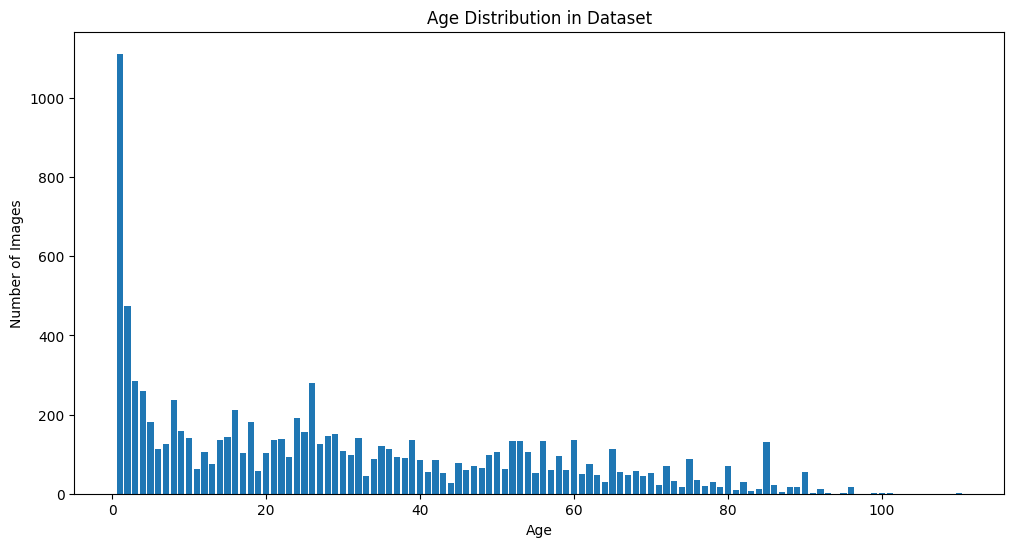

In [53]:
# Count the number of images per age
age_counts = []
for age_folder in os.listdir(path):
    if age_folder != '.DS_Store':
        age = int(age_folder)
        age_count = len(os.listdir(os.path.join(path, age_folder)))
        age_counts.append((age, age_count))

# Create a DataFrame and sort by age
age_df = pd.DataFrame(age_counts, columns=['age', 'count'])
age_df = age_df.sort_values('age')

# Plot the age distribution
plt.figure(figsize=(12, 6))
plt.bar(age_df['age'], age_df['count'])
plt.xlabel('Age')
plt.ylabel('Number of Images')
plt.title('Age Distribution in Dataset')
plt.show()

In [54]:
max_images_per_age = 300
max_age = 90  # new variable

# Count the number of images per age
age_counts = []
for age_folder in os.listdir(path):
    if age_folder != '.DS_Store':
        age = int(age_folder)
        if age <= max_age:  # only process if age is <= max_age
            image_names = os.listdir(os.path.join(path, age_folder))
            age_count = len(image_names)
            if age_count > max_images_per_age:
                # Randomly select max_images_per_age from the list
                image_names = random.sample(image_names, max_images_per_age)
            age_counts.append((age, len(image_names)))

            # Now save these images to a new directory
            new_folder_path = os.path.join(new_folder, age_folder)
            os.makedirs(new_folder_path, exist_ok=True)
            for image_name in image_names:
                old_image_path = os.path.join(path, age_folder, image_name)
                new_image_path = os.path.join(new_folder_path, image_name)
                shutil.copyfile(old_image_path, new_image_path)

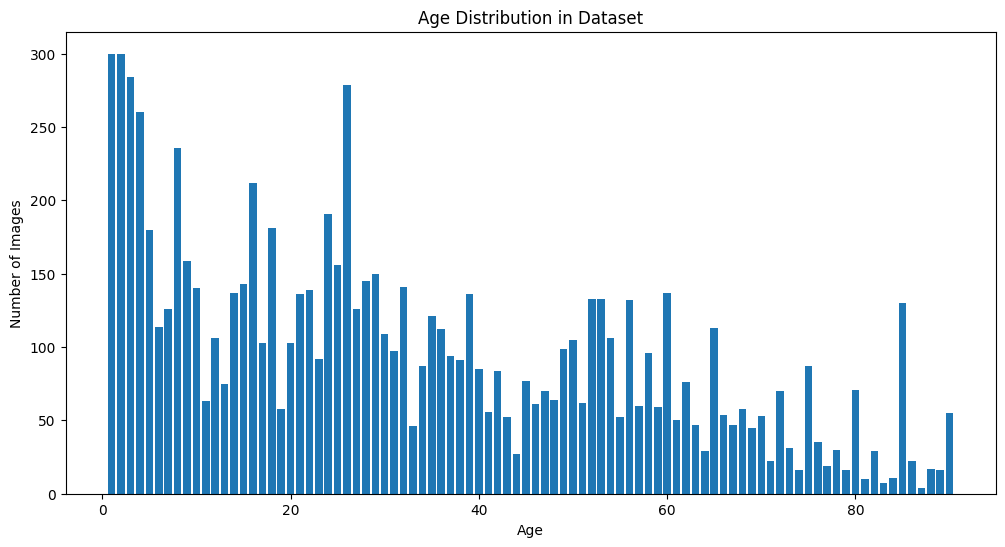

In [55]:
# Plot more balanced data

# Create a DataFrame and sort by age
age_df = pd.DataFrame(age_counts, columns=['age', 'count'])
age_df = age_df.sort_values('age')

# Plot the age distribution
plt.figure(figsize=(12, 6))
plt.bar(age_df['age'], age_df['count'])
plt.xlabel('Age')
plt.ylabel('Number of Images')
plt.title('Age Distribution in Dataset')
plt.show()

### Train test val split raw data

In [56]:
# assuming your data is stored in a list of tuples (image_path, age)
data = [(os.path.join(new_folder, age_folder, img), age_folder) 
        for age_folder in os.listdir(new_folder) 
        if age_folder != '.DS_Store' 
        for img in os.listdir(os.path.join(new_folder, age_folder))]

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.20, random_state=42)

### Save train test val split

In [57]:
def move_files(data, target_folder):
    new_data = []  # a list to store the new file paths
    os.makedirs(target_folder, exist_ok=True)
    for filepath, age in data:
        # create a subfolder for each age if it doesn't exist already
        age_folder = os.path.join(target_folder, age)
        os.makedirs(age_folder, exist_ok=True)
        
        # move the file to the new folder
        target_path = os.path.join(age_folder, os.path.basename(filepath))
        shutil.move(filepath, target_path)
        
        # add the new file path to the list
        new_data.append((target_path, age))
    
    return new_data

In [58]:
train_data = move_files(train_data, '../02_Data/face_age_balanced_train/')
val_data = move_files(val_data, '../02_Data/face_age_balanced_val/')
test_data = move_files(test_data, '../02_Data/face_age_balanced_test/')

### Calculate number of augments to perform

In [59]:
def num_augmentation(age_df, max_images=500, min_augmentation=100):
    num_augment = {}
    for index, row in age_df.iterrows():
        age = row['age']
        count = row['count']
        if count > max_images:
            num_augment[age] = count + min_augmentation
        else:
            num_augment[age] = max_images
    return num_augment

In [61]:
# Create a DataFrame for the training data
train_age_counts = []
for image_path, age in train_data:
    age = int(age)
    train_age_counts.append(age)
train_age_df = pd.DataFrame(train_age_counts, columns=['age'])
train_age_df = train_age_df['age'].value_counts().reset_index().rename(columns={'index': 'age', 'age': 'count'})

# Your num_augmentation function can stay the same
num_augment = num_augmentation(train_age_df)

# Define the augmentations you want to apply
transform = A.Compose([
    A.HorizontalFlip(p=0.25),
    A.Rotate(limit=30, p=0.3),
    A.RandomBrightnessContrast(p=0.3),
    A.GaussianBlur(blur_limit=3, p=0.3),
    A.HueSaturationValue(p=0.3),
    A.GaussNoise(var_limit=(100.0, 500.0), p=0.2),
    A.CLAHE(p=0.2)
])

new_folder = '../02_Data/augmented_data_train/'

# check if augmented_data folder exists (delete if exists)
if os.path.exists(new_folder):
    shutil.rmtree(new_folder)

# Group the training data by age
train_data_by_age = defaultdict(list)
for image_path, age in train_data:
    train_data_by_age[int(age)].append(image_path)

# Loop through each age group in the training data
for age, image_paths in train_data_by_age.items():
    # Define the folder path and create a new folder for the augmented images
    folder_name = str(age).zfill(3)  # '001', '002', etc.
    new_folder_path = os.path.join(new_folder, f"aug_{folder_name}")
    os.makedirs(new_folder_path, exist_ok=True)
    
    # Calculate the total images needed for this age
    total_images_needed = num_augment[age] - len(image_paths)
    
    if total_images_needed > 0:
        # loop through the entire folder floor(total_image_need / total_image_have)
        for i in range(total_images_needed // len(image_paths)):   
            for image_path in image_paths:
                # Load the image
                image = cv2.imread(image_path)
                
                # Apply the augmentations to the image
                augmented = transform(image=image)
                augmented_image = augmented["image"]
                
                # Save the augmented image to the new folder
                image_name = os.path.basename(image_path)  # get the image filename
                new_image_path = os.path.join(new_folder_path, f"aug_{image_name}_{i}")
                cv2.imwrite(new_image_path, augmented_image)
        
        # randomly augment remaining (total_image_need % total_image_have) image to have the same number
        remaining_img = total_images_needed % len(image_paths)
        count = 0
        for image_path in image_paths:
            
            if count >= remaining_img:
                break
            
            # Load the image
            image = cv2.imread(image_path)
            
            # Apply the augmentations to the image
            augmented = transform(image=image)
            augmented_image = augmented["image"]
            
            # Save the augmented image to the new folder
            image_name = os.path.basename(image_path)  # get the image filename
            new_image_path = os.path.join(new_folder_path, f"aug_{image_name}_r")
            cv2.imwrite(new_image_path, augmented_image)
            
            count += 1

/nfs/home/sms5736/.local/lib/python3.9/site-packages/albumentations/augmentations/blur/transforms.py:184: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  warnings.warn(


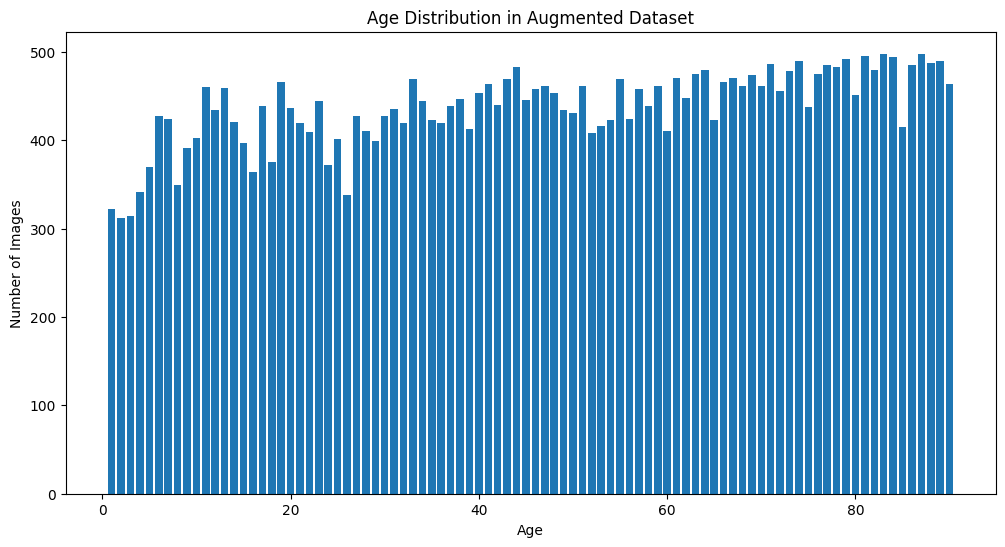

In [62]:
# Count the number of images per age in the augmented_data folder
augmented_path = '../02_Data/augmented_data_train/'
augmented_age_counts = []

for age_folder in os.listdir(augmented_path):
    if age_folder.startswith('aug_'):
        age = int(age_folder.split('_')[1])
        age_count = len(os.listdir(os.path.join(augmented_path, age_folder)))
        augmented_age_counts.append((age, age_count))

# Create a DataFrame and sort by age
augmented_age_df = pd.DataFrame(augmented_age_counts, columns=['age', 'count'])
augmented_age_df = augmented_age_df.sort_values('age')

# Plot the age distribution for augmented images
plt.figure(figsize=(12, 6))
plt.bar(augmented_age_df['age'], augmented_age_df['count'])
plt.xlabel('Age')
plt.ylabel('Number of Images')
plt.title('Age Distribution in Augmented Dataset')
plt.show()

Ha!